### Inference notebook:
- https://www.kaggle.com/code/ravaghi/skin-cancer-detection-resnet50-inference

# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import h5py
import torch
import random
import timm
import cv2
import io
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    train_img_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5'
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/working/checkpoints'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    max_epochs = 100
    learning_rate = 5e-4
    weight_decay = 1e-6
    min_lr = 1e-7
    train_batch_size = 32
    val_batch_size = 64
    n_folds = 5
    seed = 35555
    model_name = "resnet50"
    es_patience = 15

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

# Loading and splitting the datasets

In [4]:
train_metadata = pd.read_csv(CFG.train_metadata_path)

positives = train_metadata[train_metadata.target == 1]
negatives = train_metadata[train_metadata.target == 0]
train_metadata = pd.concat([positives, negatives.sample(n=20 * len(positives), random_state=CFG.seed)])
train_metadata = train_metadata.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

In [5]:
sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata, train_metadata.target, groups=train_metadata.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata.loc[val_index, 'fold'] = i

In [6]:
train_metadata2 = pd.read_csv(CFG.train_metadata_path)

sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata2, train_metadata2.target, groups=train_metadata2.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata2.loc[val_index, 'fold'] = i

In [7]:
CFG.t_max = train_metadata.shape[0] * (CFG.n_folds-1) * CFG.max_epochs // CFG.train_batch_size // CFG.n_folds

# Creating a custom image dataset

In [8]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [9]:
# Reference: https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only

transforms = {
    "train": A.Compose([
        A.Resize(224, 224),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=60,
            p=0.5
        ),
        A.HueSaturationValue(
            hue_shift_limit=0.2,
            sat_shift_limit=0.2,
            val_shift_limit=0.2,
            p=0.5
        ),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1),
            contrast_limit=(-0.1, 0.1),
            p=0.5
        ),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2()], p=1.),

    "val": A.Compose([
        A.Resize(224, 224),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2()], p=1.)
}

# Customizing the image model

In [10]:
class ResNet(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(ResNet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        num_features = 1000
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

# Creating a trainer class

In [11]:
class Trainer:
    def __init__(
        self,
        device,
        model,
        criterion,
        optimizer,
        scheduler,
        train_dataloader,
        val_dataloader,
        checkpoint_path,
        fold_idx,
        es_patience
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_pauc = 0.0
        self.best_model_path = None
        self.fold_idx = fold_idx
        self.es_patience = es_patience
        self.create_checkpoint_path()

    def create_checkpoint_path(self):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)

    @staticmethod
    def p_roc_auc_score(y_true, y_preds, min_tpr: float = 0.80):
        v_gt = abs(np.asarray(y_true)-1)
        v_pred = -1.0 * np.asarray(y_preds)
        max_fpr = abs(1-min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)
        return partial_auc

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

            self.optimizer.zero_grad()

            y_hat = self.model(x).squeeze()

            preds.extend(y_hat.detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())

            loss = self.criterion(y_hat, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_loss=round(running_loss / total, 6))

            if self.scheduler is not None:
                self.scheduler.step()

        train_pauc = self.p_roc_auc_score(targets, preds)
        train_loss = running_loss / num_batches

        return train_pauc, train_loss

    def evaluate(self, current_epoch_nr):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

                self.optimizer.zero_grad()

                y_hat = self.model(x).squeeze()
                
                preds.extend(y_hat.detach().cpu().numpy())
                targets.extend(y.detach().cpu().numpy())

                loss = self.criterion(y_hat, y)
                running_loss += loss.item() * x.size(0)
                total += y.size(0)

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_loss=round(running_loss / total, 6))

        val_pauc = self.p_roc_auc_score(targets, preds)
        val_loss = running_loss / num_batches

        if val_pauc > self.best_pauc:
            self.es_patience = CFG.es_patience
            if self.best_pauc != 0.0:
                print(f'New best model found: pAUC = {val_pauc:.6f} (previous best: {self.best_pauc:.6f})')
            self.best_pauc = val_pauc
            checkpoint_name = f'fold_{self.fold_idx}_epoch_{current_epoch_nr}_pauc_{round(val_pauc, 6)}.pth'

            for file in os.listdir(self.checkpoint_path):
                if file.startswith(f'fold_{self.fold_idx}_epoch_'):
                    os.remove(os.path.join(self.checkpoint_path, file))

            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(
                self.checkpoint_path, checkpoint_name)

        else:
            self.es_patience -= 1
            if self.es_patience == 0:
                print(f'Early stopping triggered at epoch {current_epoch_nr}. Best pAUC = {self.best_pauc:.6f}')
                return val_pauc, val_loss, True

        return val_pauc, val_loss, False

    def predict(self, dataloader):
        model = self.model.to(self.device)
        model.load_state_dict(torch.load(self.best_model_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(dataloader, total=len(dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device, dtype=torch.float)
                y_hat = model(x).squeeze()
                preds.extend(y_hat.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

# Training and cross-validation

In [12]:
histories = {}
oof_pred_probs_df = []

for fold_idx in range(CFG.n_folds):
    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------')

    _train = train_metadata[train_metadata['fold'] != fold_idx]
    train_dataset = ISICDataset(CFG.train_img_path, _train, transforms['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=4)

    _val = train_metadata[train_metadata['fold'] == fold_idx]
    val_dataset = ISICDataset(CFG.train_img_path, _val, transforms['val'])
    val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    _val2 = train_metadata2[train_metadata2['fold'] == fold_idx]
    val_dataset2 = ISICDataset(CFG.train_img_path, _val2, transforms['val'])
    val_dataloader2 = DataLoader(val_dataset2, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    model = ResNet(CFG.model_name).to(CFG.device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    t_max = len(train_dataloader) * CFG.max_epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.t_max, eta_min=CFG.min_lr)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        checkpoint_path=CFG.checkpoint_path,
        fold_idx=fold_idx,
        es_patience=CFG.es_patience
    )

    history = {
        'epoch': [],
        'train_pauc': [],
        'train_loss': [],
        'val_pauc': [],
        'val_loss': []
    }
    for epoch in range(1, CFG.max_epochs + 1):
        train_pauc, train_loss = trainer.train(current_epoch_nr=epoch)
        val_pauc, val_loss, es_triggered = trainer.evaluate(current_epoch_nr=epoch)

        print(f"Epoch {epoch}: Train pAUC: {train_pauc:.6f} - Val pAUC: {val_pauc:.6f} | Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}\n")

        history['epoch'].append(epoch)
        history['train_pauc'].append(train_pauc)
        history['train_loss'].append(train_loss)
        history['val_pauc'].append(val_pauc)
        history['val_loss'].append(val_loss)

        if es_triggered:
            break

    histories[f'Fold {fold_idx + 1}'] = history

    pred_probs = trainer.predict(val_dataloader2)
    _val2[CFG.model_name] = pred_probs
    oof_pred_probs_df.append(_val2)

    del _train, _val, train_dataset, val_dataset, model, criterion, optimizer, scheduler, trainer
    gc.collect()
    torch.cuda.empty_cache()

    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------\n\n')

---------------------------------- Fold 1 ----------------------------------


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 25/25 [00:03<00:00,  6.57it/s, val_loss=0.152]


Epoch 1: Train pAUC: 0.052074 - Val pAUC: 0.069680 | Train Loss: 7.047657 - Val Loss: 9.664161



Epoch 2: 100%|██████████| 25/25 [00:03<00:00,  7.36it/s, val_loss=0.143]


New best model found: pAUC = 0.098542 (previous best: 0.069680)
Epoch 2: Train pAUC: 0.077319 - Val pAUC: 0.098542 | Train Loss: 5.127893 - Val Loss: 9.116517



Epoch 3: 100%|██████████| 25/25 [00:03<00:00,  7.36it/s, val_loss=0.134]


Epoch 3: Train pAUC: 0.100911 - Val pAUC: 0.084651 | Train Loss: 4.582252 - Val Loss: 8.518811



Epoch 4: 100%|██████████| 25/25 [00:03<00:00,  7.34it/s, val_loss=0.165]


Epoch 4: Train pAUC: 0.115448 - Val pAUC: 0.070598 | Train Loss: 4.233697 - Val Loss: 10.462660



Epoch 5: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s, val_loss=0.139]


New best model found: pAUC = 0.109770 (previous best: 0.098542)
Epoch 5: Train pAUC: 0.127390 - Val pAUC: 0.109770 | Train Loss: 4.082265 - Val Loss: 8.863545



Epoch 6: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s, val_loss=0.123]


New best model found: pAUC = 0.112868 (previous best: 0.109770)
Epoch 6: Train pAUC: 0.124307 - Val pAUC: 0.112868 | Train Loss: 4.104859 - Val Loss: 7.822858



Epoch 7: 100%|██████████| 25/25 [00:03<00:00,  7.44it/s, val_loss=0.12]


Epoch 7: Train pAUC: 0.131561 - Val pAUC: 0.110648 | Train Loss: 3.968179 - Val Loss: 7.603316



Epoch 8: 100%|██████████| 25/25 [00:03<00:00,  7.34it/s, val_loss=0.118]


New best model found: pAUC = 0.116126 (previous best: 0.112868)
Epoch 8: Train pAUC: 0.133561 - Val pAUC: 0.116126 | Train Loss: 3.807569 - Val Loss: 7.488785



Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.52it/s, val_loss=0.115]


Epoch 9: Train pAUC: 0.142759 - Val pAUC: 0.109559 | Train Loss: 3.651906 - Val Loss: 7.343095



Epoch 10: 100%|██████████| 25/25 [00:03<00:00,  7.49it/s, val_loss=0.13]


Epoch 10: Train pAUC: 0.141387 - Val pAUC: 0.114784 | Train Loss: 3.608823 - Val Loss: 8.292560



Epoch 11: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s, val_loss=0.119]


New best model found: pAUC = 0.134144 (previous best: 0.116126)
Epoch 11: Train pAUC: 0.150673 - Val pAUC: 0.134144 | Train Loss: 3.406003 - Val Loss: 7.542065



Epoch 12: 100%|██████████| 25/25 [00:03<00:00,  7.52it/s, val_loss=0.128]


Epoch 12: Train pAUC: 0.153585 - Val pAUC: 0.109821 | Train Loss: 3.512422 - Val Loss: 8.123756



Epoch 13: 100%|██████████| 25/25 [00:03<00:00,  7.34it/s, val_loss=0.123]


Epoch 13: Train pAUC: 0.155870 - Val pAUC: 0.119193 | Train Loss: 3.373959 - Val Loss: 7.830372



Epoch 14: 100%|██████████| 25/25 [00:03<00:00,  7.45it/s, val_loss=0.115]


Epoch 14: Train pAUC: 0.156077 - Val pAUC: 0.119828 | Train Loss: 3.286717 - Val Loss: 7.342367



Epoch 15: 100%|██████████| 25/25 [00:03<00:00,  7.53it/s, val_loss=0.108]


New best model found: pAUC = 0.139047 (previous best: 0.134144)
Epoch 15: Train pAUC: 0.154068 - Val pAUC: 0.139047 | Train Loss: 3.334767 - Val Loss: 6.864036



Epoch 16: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, val_loss=0.128]


Epoch 16: Train pAUC: 0.159990 - Val pAUC: 0.132398 | Train Loss: 3.145783 - Val Loss: 8.146438



Epoch 17: 100%|██████████| 25/25 [00:03<00:00,  7.47it/s, val_loss=0.129]


Epoch 17: Train pAUC: 0.164695 - Val pAUC: 0.122754 | Train Loss: 3.097978 - Val Loss: 8.204182



Epoch 18: 100%|██████████| 25/25 [00:03<00:00,  7.44it/s, val_loss=0.121]


Epoch 18: Train pAUC: 0.157604 - Val pAUC: 0.132429 | Train Loss: 3.212541 - Val Loss: 7.676479



Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.49it/s, val_loss=0.125]


Epoch 19: Train pAUC: 0.160272 - Val pAUC: 0.119677 | Train Loss: 2.973844 - Val Loss: 7.930865



Epoch 20: 100%|██████████| 25/25 [00:03<00:00,  7.39it/s, val_loss=0.128]


Epoch 20: Train pAUC: 0.167787 - Val pAUC: 0.123692 | Train Loss: 2.790458 - Val Loss: 8.128161



Epoch 21: 100%|██████████| 25/25 [00:03<00:00,  7.47it/s, val_loss=0.128]


New best model found: pAUC = 0.143919 (previous best: 0.139047)
Epoch 21: Train pAUC: 0.162524 - Val pAUC: 0.143919 | Train Loss: 2.834538 - Val Loss: 8.141475



Epoch 22: 100%|██████████| 25/25 [00:03<00:00,  7.49it/s, val_loss=0.129]


New best model found: pAUC = 0.146260 (previous best: 0.143919)
Epoch 22: Train pAUC: 0.155166 - Val pAUC: 0.146260 | Train Loss: 3.092126 - Val Loss: 8.229552



Epoch 23: 100%|██████████| 25/25 [00:03<00:00,  7.38it/s, val_loss=0.131]


Epoch 23: Train pAUC: 0.165507 - Val pAUC: 0.136979 | Train Loss: 2.774631 - Val Loss: 8.314970



Epoch 24: 100%|██████████| 25/25 [00:03<00:00,  7.36it/s, val_loss=0.116]


New best model found: pAUC = 0.150043 (previous best: 0.146260)
Epoch 24: Train pAUC: 0.176825 - Val pAUC: 0.150043 | Train Loss: 2.420111 - Val Loss: 7.355912



Epoch 25: 100%|██████████| 25/25 [00:03<00:00,  7.44it/s, val_loss=0.145]


Epoch 25: Train pAUC: 0.170467 - Val pAUC: 0.133337 | Train Loss: 2.519713 - Val Loss: 9.208832



Epoch 26: 100%|██████████| 25/25 [00:03<00:00,  7.31it/s, val_loss=0.134]


Epoch 26: Train pAUC: 0.176879 - Val pAUC: 0.134759 | Train Loss: 2.319622 - Val Loss: 8.517562



Epoch 27: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s, val_loss=0.128]


New best model found: pAUC = 0.150436 (previous best: 0.150043)
Epoch 27: Train pAUC: 0.175807 - Val pAUC: 0.150436 | Train Loss: 2.467710 - Val Loss: 8.131591



Epoch 28: 100%|██████████| 25/25 [00:03<00:00,  7.47it/s, val_loss=0.131]


Epoch 28: Train pAUC: 0.180139 - Val pAUC: 0.125095 | Train Loss: 2.239840 - Val Loss: 8.325198



Epoch 29: 100%|██████████| 25/25 [00:03<00:00,  7.46it/s, val_loss=0.125]


Epoch 29: Train pAUC: 0.182110 - Val pAUC: 0.140852 | Train Loss: 2.247512 - Val Loss: 7.921723



Epoch 30: 100%|██████████| 25/25 [00:03<00:00,  6.77it/s, val_loss=0.151]


Epoch 30: Train pAUC: 0.183742 - Val pAUC: 0.126789 | Train Loss: 2.071706 - Val Loss: 9.606470



Epoch 31: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s, val_loss=0.149]


Epoch 31: Train pAUC: 0.187413 - Val pAUC: 0.133256 | Train Loss: 1.835932 - Val Loss: 9.475526



Epoch 32: 100%|██████████| 25/25 [00:03<00:00,  7.44it/s, val_loss=0.173]


Epoch 32: Train pAUC: 0.186127 - Val pAUC: 0.130673 | Train Loss: 2.034743 - Val Loss: 11.018596



Epoch 33: 100%|██████████| 25/25 [00:03<00:00,  7.03it/s, val_loss=0.162]


Epoch 33: Train pAUC: 0.185328 - Val pAUC: 0.139894 | Train Loss: 1.884452 - Val Loss: 10.290600



Epoch 34: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, val_loss=0.149]


Epoch 34: Train pAUC: 0.190472 - Val pAUC: 0.139571 | Train Loss: 1.707961 - Val Loss: 9.458932



Epoch 35: 100%|██████████| 25/25 [00:03<00:00,  7.06it/s, val_loss=0.168]


Epoch 35: Train pAUC: 0.185549 - Val pAUC: 0.121725 | Train Loss: 1.789401 - Val Loss: 10.702170



Epoch 36: 100%|██████████| 25/25 [00:03<00:00,  7.32it/s, val_loss=0.152]


Epoch 36: Train pAUC: 0.188787 - Val pAUC: 0.118305 | Train Loss: 1.675678 - Val Loss: 9.637612



Epoch 37: 100%|██████████| 25/25 [00:03<00:00,  7.45it/s, val_loss=0.141]


Epoch 37: Train pAUC: 0.190305 - Val pAUC: 0.133397 | Train Loss: 1.724689 - Val Loss: 8.954341



Epoch 38: 100%|██████████| 25/25 [00:03<00:00,  7.48it/s, val_loss=0.152]


Epoch 38: Train pAUC: 0.191553 - Val pAUC: 0.132661 | Train Loss: 1.468370 - Val Loss: 9.680774



Epoch 39: 100%|██████████| 25/25 [00:03<00:00,  7.03it/s, val_loss=0.164]


Epoch 39: Train pAUC: 0.193468 - Val pAUC: 0.126144 | Train Loss: 1.382452 - Val Loss: 10.460773



Epoch 40: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, val_loss=0.169]


Epoch 40: Train pAUC: 0.192088 - Val pAUC: 0.139511 | Train Loss: 1.494244 - Val Loss: 10.737002



Epoch 41: 100%|██████████| 25/25 [00:03<00:00,  6.98it/s, val_loss=0.195]


Epoch 41: Train pAUC: 0.193520 - Val pAUC: 0.145211 | Train Loss: 1.214986 - Val Loss: 12.380279



Epoch 42: 100%|██████████| 25/25 [00:03<00:00,  7.45it/s, val_loss=0.19]


Early stopping triggered at epoch 42. Best pAUC = 0.150436
Epoch 42: Train pAUC: 0.195116 - Val pAUC: 0.135677 | Train Loss: 1.166981 - Val Loss: 12.071528



Prediction: 100%|██████████| 1211/1211 [02:18<00:00,  8.72it/s]


---------------------------------- Fold 1 ----------------------------------


---------------------------------- Fold 2 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.144]


Epoch 1: Train pAUC: 0.049246 - Val pAUC: 0.078781 | Train Loss: 7.077338 - Val Loss: 9.087627



Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.133]


New best model found: pAUC = 0.112148 (previous best: 0.078781)
Epoch 2: Train pAUC: 0.091848 - Val pAUC: 0.112148 | Train Loss: 5.110620 - Val Loss: 8.374949



Epoch 3: 100%|██████████| 29/29 [00:03<00:00,  7.67it/s, val_loss=0.116]


New best model found: pAUC = 0.122261 (previous best: 0.112148)
Epoch 3: Train pAUC: 0.090811 - Val pAUC: 0.122261 | Train Loss: 4.840625 - Val Loss: 7.311854



Epoch 4: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.107]


New best model found: pAUC = 0.138109 (previous best: 0.122261)
Epoch 4: Train pAUC: 0.111786 - Val pAUC: 0.138109 | Train Loss: 4.492480 - Val Loss: 6.723204



Epoch 5: 100%|██████████| 29/29 [00:03<00:00,  7.58it/s, val_loss=0.132]


Epoch 5: Train pAUC: 0.108534 - Val pAUC: 0.135704 | Train Loss: 4.251321 - Val Loss: 8.327551



Epoch 6: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.108]


Epoch 6: Train pAUC: 0.119867 - Val pAUC: 0.131309 | Train Loss: 4.195783 - Val Loss: 6.778249



Epoch 7: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.104]


Epoch 7: Train pAUC: 0.136012 - Val pAUC: 0.118800 | Train Loss: 4.003351 - Val Loss: 6.571244



Epoch 8: 100%|██████████| 29/29 [00:03<00:00,  7.45it/s, val_loss=0.108]


Epoch 8: Train pAUC: 0.140930 - Val pAUC: 0.134936 | Train Loss: 3.813325 - Val Loss: 6.825875



Epoch 9: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.0961]


New best model found: pAUC = 0.143497 (previous best: 0.138109)
Epoch 9: Train pAUC: 0.138948 - Val pAUC: 0.143497 | Train Loss: 3.971427 - Val Loss: 6.056166



Epoch 10: 100%|██████████| 29/29 [00:03<00:00,  7.63it/s, val_loss=0.113]


Epoch 10: Train pAUC: 0.153174 - Val pAUC: 0.127901 | Train Loss: 3.649617 - Val Loss: 7.152601



Epoch 11: 100%|██████████| 29/29 [00:03<00:00,  7.46it/s, val_loss=0.101]


Epoch 11: Train pAUC: 0.148719 - Val pAUC: 0.132753 | Train Loss: 3.675413 - Val Loss: 6.384163



Epoch 12: 100%|██████████| 29/29 [00:03<00:00,  7.63it/s, val_loss=0.105]


Epoch 12: Train pAUC: 0.156183 - Val pAUC: 0.141889 | Train Loss: 3.591408 - Val Loss: 6.625782



Epoch 13: 100%|██████████| 29/29 [00:03<00:00,  7.63it/s, val_loss=0.103]


Epoch 13: Train pAUC: 0.149015 - Val pAUC: 0.134130 | Train Loss: 3.592804 - Val Loss: 6.485759



Epoch 14: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.101]


New best model found: pAUC = 0.156022 (previous best: 0.143497)
Epoch 14: Train pAUC: 0.157510 - Val pAUC: 0.156022 | Train Loss: 3.494318 - Val Loss: 6.347137



Epoch 15: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.0954]


Epoch 15: Train pAUC: 0.158346 - Val pAUC: 0.146417 | Train Loss: 3.400235 - Val Loss: 6.012766



Epoch 16: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.101]


Epoch 16: Train pAUC: 0.162829 - Val pAUC: 0.144340 | Train Loss: 3.288303 - Val Loss: 6.383876



Epoch 17: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.112]


Epoch 17: Train pAUC: 0.170538 - Val pAUC: 0.148943 | Train Loss: 3.044849 - Val Loss: 7.048805



Epoch 18: 100%|██████████| 29/29 [00:03<00:00,  7.43it/s, val_loss=0.105]


Epoch 18: Train pAUC: 0.166782 - Val pAUC: 0.137890 | Train Loss: 3.186758 - Val Loss: 6.631644



Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.127]


Epoch 19: Train pAUC: 0.164679 - Val pAUC: 0.110988 | Train Loss: 3.055601 - Val Loss: 7.997150



Epoch 20: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.111]


Epoch 20: Train pAUC: 0.162561 - Val pAUC: 0.145679 | Train Loss: 3.286959 - Val Loss: 7.017832



Epoch 21: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.107]


Epoch 21: Train pAUC: 0.168139 - Val pAUC: 0.148541 | Train Loss: 2.953584 - Val Loss: 6.737812



Epoch 22: 100%|██████████| 29/29 [00:03<00:00,  7.58it/s, val_loss=0.0968]


Epoch 22: Train pAUC: 0.171623 - Val pAUC: 0.145989 | Train Loss: 2.928839 - Val Loss: 6.100681



Epoch 23: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.106]


Epoch 23: Train pAUC: 0.174641 - Val pAUC: 0.132930 | Train Loss: 2.827011 - Val Loss: 6.695894



Epoch 24: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, val_loss=0.108]


New best model found: pAUC = 0.157117 (previous best: 0.156022)
Epoch 24: Train pAUC: 0.172714 - Val pAUC: 0.157117 | Train Loss: 2.763722 - Val Loss: 6.827051



Epoch 25: 100%|██████████| 29/29 [00:03<00:00,  7.64it/s, val_loss=0.107]


Epoch 25: Train pAUC: 0.173411 - Val pAUC: 0.149706 | Train Loss: 2.703730 - Val Loss: 6.750143



Epoch 26: 100%|██████████| 29/29 [00:03<00:00,  7.68it/s, val_loss=0.122]


Epoch 26: Train pAUC: 0.178569 - Val pAUC: 0.141548 | Train Loss: 2.586975 - Val Loss: 7.696052



Epoch 27: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.0985]


Epoch 27: Train pAUC: 0.177681 - Val pAUC: 0.146122 | Train Loss: 2.576155 - Val Loss: 6.205787



Epoch 28: 100%|██████████| 29/29 [00:03<00:00,  7.63it/s, val_loss=0.126]


Epoch 28: Train pAUC: 0.177434 - Val pAUC: 0.143474 | Train Loss: 2.548236 - Val Loss: 7.969172



Epoch 29: 100%|██████████| 29/29 [00:04<00:00,  7.21it/s, val_loss=0.137]


Epoch 29: Train pAUC: 0.185689 - Val pAUC: 0.129716 | Train Loss: 2.207294 - Val Loss: 8.607513



Epoch 30: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.117]


Epoch 30: Train pAUC: 0.180306 - Val pAUC: 0.150096 | Train Loss: 2.374030 - Val Loss: 7.372219



Epoch 31: 100%|██████████| 29/29 [00:03<00:00,  7.64it/s, val_loss=0.126]


Epoch 31: Train pAUC: 0.188234 - Val pAUC: 0.129497 | Train Loss: 2.062608 - Val Loss: 7.921511



Epoch 32: 100%|██████████| 29/29 [00:03<00:00,  7.46it/s, val_loss=0.114]


Epoch 32: Train pAUC: 0.180346 - Val pAUC: 0.143453 | Train Loss: 2.406351 - Val Loss: 7.214619



Epoch 33: 100%|██████████| 29/29 [00:04<00:00,  7.22it/s, val_loss=0.135]


Epoch 33: Train pAUC: 0.189701 - Val pAUC: 0.132308 | Train Loss: 1.924224 - Val Loss: 8.519804



Epoch 34: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.111]


Epoch 34: Train pAUC: 0.184289 - Val pAUC: 0.141359 | Train Loss: 1.999164 - Val Loss: 7.009325



Epoch 35: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.119]


Epoch 35: Train pAUC: 0.188287 - Val pAUC: 0.134485 | Train Loss: 1.899832 - Val Loss: 7.499899



Epoch 36: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, val_loss=0.13]


Epoch 36: Train pAUC: 0.189888 - Val pAUC: 0.134130 | Train Loss: 1.670168 - Val Loss: 8.182531



Epoch 37: 100%|██████████| 29/29 [00:03<00:00,  7.39it/s, val_loss=0.14]


Epoch 37: Train pAUC: 0.189054 - Val pAUC: 0.121802 | Train Loss: 1.891592 - Val Loss: 8.802789



Epoch 38: 100%|██████████| 29/29 [00:03<00:00,  7.65it/s, val_loss=0.136]


Epoch 38: Train pAUC: 0.186833 - Val pAUC: 0.123657 | Train Loss: 1.812630 - Val Loss: 8.588269



Epoch 39: 100%|██████████| 29/29 [00:03<00:00,  7.65it/s, val_loss=0.134]


Early stopping triggered at epoch 39. Best pAUC = 0.157117
Epoch 39: Train pAUC: 0.187899 - Val pAUC: 0.144339 | Train Loss: 1.813736 - Val Loss: 8.449919



Prediction: 100%|██████████| 1310/1310 [02:31<00:00,  8.64it/s]


---------------------------------- Fold 2 ----------------------------------


---------------------------------- Fold 3 ----------------------------------


Epoch 1: 100%|██████████| 21/21 [00:02<00:00,  7.34it/s, val_loss=0.185]


Epoch 1: Train pAUC: 0.049936 - Val pAUC: 0.094194 | Train Loss: 6.703091 - Val Loss: 11.505826



Epoch 2: 100%|██████████| 21/21 [00:02<00:00,  7.33it/s, val_loss=0.161]


New best model found: pAUC = 0.106165 (previous best: 0.094194)
Epoch 2: Train pAUC: 0.082020 - Val pAUC: 0.106165 | Train Loss: 4.815678 - Val Loss: 9.985475



Epoch 3: 100%|██████████| 21/21 [00:02<00:00,  7.32it/s, val_loss=0.143]


New best model found: pAUC = 0.110614 (previous best: 0.106165)
Epoch 3: Train pAUC: 0.096794 - Val pAUC: 0.110614 | Train Loss: 4.489910 - Val Loss: 8.868734



Epoch 4: 100%|██████████| 21/21 [00:02<00:00,  7.08it/s, val_loss=0.154]


New best model found: pAUC = 0.113008 (previous best: 0.110614)
Epoch 4: Train pAUC: 0.116306 - Val pAUC: 0.113008 | Train Loss: 4.123896 - Val Loss: 9.558457



Epoch 5: 100%|██████████| 21/21 [00:02<00:00,  7.38it/s, val_loss=0.132]


New best model found: pAUC = 0.141953 (previous best: 0.113008)
Epoch 5: Train pAUC: 0.121505 - Val pAUC: 0.141953 | Train Loss: 4.024015 - Val Loss: 8.226170



Epoch 6: 100%|██████████| 21/21 [00:02<00:00,  7.31it/s, val_loss=0.142]


Epoch 6: Train pAUC: 0.126407 - Val pAUC: 0.107513 | Train Loss: 4.043385 - Val Loss: 8.833256



Epoch 7: 100%|██████████| 21/21 [00:02<00:00,  7.30it/s, val_loss=0.136]


Epoch 7: Train pAUC: 0.141988 - Val pAUC: 0.135047 | Train Loss: 3.815765 - Val Loss: 8.450433



Epoch 8: 100%|██████████| 21/21 [00:02<00:00,  7.30it/s, val_loss=0.153]


Epoch 8: Train pAUC: 0.145068 - Val pAUC: 0.101811 | Train Loss: 3.710499 - Val Loss: 9.517305



Epoch 9: 100%|██████████| 21/21 [00:02<00:00,  7.25it/s, val_loss=0.155]


Epoch 9: Train pAUC: 0.137545 - Val pAUC: 0.109505 | Train Loss: 3.742601 - Val Loss: 9.631216



Epoch 10: 100%|██████████| 21/21 [00:02<00:00,  7.27it/s, val_loss=0.122]


New best model found: pAUC = 0.152480 (previous best: 0.141953)
Epoch 10: Train pAUC: 0.140260 - Val pAUC: 0.152480 | Train Loss: 3.633859 - Val Loss: 7.554316



Epoch 11: 100%|██████████| 21/21 [00:02<00:00,  7.00it/s, val_loss=0.122]


Epoch 11: Train pAUC: 0.141622 - Val pAUC: 0.146688 | Train Loss: 3.576350 - Val Loss: 7.565533



Epoch 12: 100%|██████████| 21/21 [00:02<00:00,  7.29it/s, val_loss=0.125]


Epoch 12: Train pAUC: 0.153420 - Val pAUC: 0.144882 | Train Loss: 3.448456 - Val Loss: 7.762383



Epoch 13: 100%|██████████| 21/21 [00:02<00:00,  7.29it/s, val_loss=0.13]


Epoch 13: Train pAUC: 0.151278 - Val pAUC: 0.138567 | Train Loss: 3.323743 - Val Loss: 8.054839



Epoch 14: 100%|██████████| 21/21 [00:02<00:00,  7.39it/s, val_loss=0.141]


Epoch 14: Train pAUC: 0.157035 - Val pAUC: 0.150652 | Train Loss: 3.350685 - Val Loss: 8.786274



Epoch 15: 100%|██████████| 21/21 [00:02<00:00,  7.33it/s, val_loss=0.141]


Epoch 15: Train pAUC: 0.152822 - Val pAUC: 0.128334 | Train Loss: 3.244253 - Val Loss: 8.777962



Epoch 16: 100%|██████████| 21/21 [00:02<00:00,  7.31it/s, val_loss=0.133]


Epoch 16: Train pAUC: 0.158783 - Val pAUC: 0.145950 | Train Loss: 3.146624 - Val Loss: 8.269869



Epoch 17: 100%|██████████| 21/21 [00:02<00:00,  7.26it/s, val_loss=0.199]


Epoch 17: Train pAUC: 0.161960 - Val pAUC: 0.141473 | Train Loss: 3.038170 - Val Loss: 12.391833



Epoch 18: 100%|██████████| 21/21 [00:02<00:00,  7.34it/s, val_loss=0.138]


Epoch 18: Train pAUC: 0.158101 - Val pAUC: 0.139281 | Train Loss: 3.141648 - Val Loss: 8.606474



Epoch 19: 100%|██████████| 21/21 [00:02<00:00,  7.12it/s, val_loss=0.127]


Epoch 19: Train pAUC: 0.164270 - Val pAUC: 0.142994 | Train Loss: 3.102392 - Val Loss: 7.899370



Epoch 20: 100%|██████████| 21/21 [00:02<00:00,  7.27it/s, val_loss=0.123]


Epoch 20: Train pAUC: 0.167161 - Val pAUC: 0.141791 | Train Loss: 2.814628 - Val Loss: 7.622542



Epoch 21: 100%|██████████| 21/21 [00:02<00:00,  7.28it/s, val_loss=0.119]


Epoch 21: Train pAUC: 0.163396 - Val pAUC: 0.152147 | Train Loss: 2.855150 - Val Loss: 7.369514



Epoch 22: 100%|██████████| 21/21 [00:02<00:00,  7.25it/s, val_loss=0.123]


Epoch 22: Train pAUC: 0.173300 - Val pAUC: 0.145258 | Train Loss: 2.643851 - Val Loss: 7.624988



Epoch 23: 100%|██████████| 21/21 [00:02<00:00,  7.26it/s, val_loss=0.12]


Epoch 23: Train pAUC: 0.165755 - Val pAUC: 0.142162 | Train Loss: 2.736300 - Val Loss: 7.448355



Epoch 24: 100%|██████████| 21/21 [00:02<00:00,  7.31it/s, val_loss=0.119]


New best model found: pAUC = 0.159436 (previous best: 0.152480)
Epoch 24: Train pAUC: 0.172079 - Val pAUC: 0.159436 | Train Loss: 2.609521 - Val Loss: 7.412380



Epoch 25: 100%|██████████| 21/21 [00:02<00:00,  7.29it/s, val_loss=0.128]


Epoch 25: Train pAUC: 0.177399 - Val pAUC: 0.140489 | Train Loss: 2.478006 - Val Loss: 7.932204



Epoch 26: 100%|██████████| 21/21 [00:02<00:00,  7.20it/s, val_loss=0.131]


Epoch 26: Train pAUC: 0.174377 - Val pAUC: 0.132621 | Train Loss: 2.439341 - Val Loss: 8.114777



Epoch 27: 100%|██████████| 21/21 [00:02<00:00,  7.32it/s, val_loss=0.131]


Epoch 27: Train pAUC: 0.180300 - Val pAUC: 0.145251 | Train Loss: 2.526889 - Val Loss: 8.113667



Epoch 28: 100%|██████████| 21/21 [00:02<00:00,  7.27it/s, val_loss=0.132]


Epoch 28: Train pAUC: 0.179839 - Val pAUC: 0.146481 | Train Loss: 2.270320 - Val Loss: 8.219883



Epoch 29: 100%|██████████| 21/21 [00:02<00:00,  7.03it/s, val_loss=0.129]


Epoch 29: Train pAUC: 0.184760 - Val pAUC: 0.145637 | Train Loss: 2.121103 - Val Loss: 7.997348



Epoch 30: 100%|██████████| 21/21 [00:02<00:00,  7.21it/s, val_loss=0.147]


Epoch 30: Train pAUC: 0.184361 - Val pAUC: 0.134203 | Train Loss: 2.025672 - Val Loss: 9.150287



Epoch 31: 100%|██████████| 21/21 [00:02<00:00,  7.22it/s, val_loss=0.131]


Epoch 31: Train pAUC: 0.169979 - Val pAUC: 0.139295 | Train Loss: 2.563012 - Val Loss: 8.152818



Epoch 32: 100%|██████████| 21/21 [00:02<00:00,  7.34it/s, val_loss=0.14]


Epoch 32: Train pAUC: 0.186073 - Val pAUC: 0.127736 | Train Loss: 2.085821 - Val Loss: 8.715183



Epoch 33: 100%|██████████| 21/21 [00:02<00:00,  7.34it/s, val_loss=0.13]


Epoch 33: Train pAUC: 0.182907 - Val pAUC: 0.148407 | Train Loss: 1.974190 - Val Loss: 8.053934



Epoch 34: 100%|██████████| 21/21 [00:02<00:00,  7.33it/s, val_loss=0.143]


Epoch 34: Train pAUC: 0.190688 - Val pAUC: 0.142830 | Train Loss: 1.686800 - Val Loss: 8.906117



Epoch 35: 100%|██████████| 21/21 [00:02<00:00,  7.24it/s, val_loss=0.145]


Epoch 35: Train pAUC: 0.185587 - Val pAUC: 0.152873 | Train Loss: 1.965555 - Val Loss: 8.987924



Epoch 36: 100%|██████████| 21/21 [00:02<00:00,  7.33it/s, val_loss=0.139]


Epoch 36: Train pAUC: 0.189125 - Val pAUC: 0.146618 | Train Loss: 1.735092 - Val Loss: 8.651104



Epoch 37: 100%|██████████| 21/21 [00:02<00:00,  7.25it/s, val_loss=0.137]


Epoch 37: Train pAUC: 0.189042 - Val pAUC: 0.151653 | Train Loss: 1.607015 - Val Loss: 8.514817



Epoch 38: 100%|██████████| 21/21 [00:02<00:00,  7.25it/s, val_loss=0.148]


Epoch 38: Train pAUC: 0.191088 - Val pAUC: 0.146703 | Train Loss: 1.556667 - Val Loss: 9.197211



Epoch 39: 100%|██████████| 21/21 [00:02<00:00,  7.21it/s, val_loss=0.167]


Early stopping triggered at epoch 39. Best pAUC = 0.159436
Epoch 39: Train pAUC: 0.190630 - Val pAUC: 0.145215 | Train Loss: 1.589060 - Val Loss: 10.376961



Prediction: 100%|██████████| 1191/1191 [02:17<00:00,  8.64it/s]


---------------------------------- Fold 3 ----------------------------------


---------------------------------- Fold 4 ----------------------------------


Epoch 1: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.156]


Epoch 1: Train pAUC: 0.046783 - Val pAUC: 0.076933 | Train Loss: 7.031541 - Val Loss: 9.826257



Epoch 2: 100%|██████████| 27/27 [00:03<00:00,  7.05it/s, val_loss=0.155]


New best model found: pAUC = 0.082661 (previous best: 0.076933)
Epoch 2: Train pAUC: 0.084814 - Val pAUC: 0.082661 | Train Loss: 5.146645 - Val Loss: 9.803248



Epoch 3: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, val_loss=0.13]


New best model found: pAUC = 0.107424 (previous best: 0.082661)
Epoch 3: Train pAUC: 0.102565 - Val pAUC: 0.107424 | Train Loss: 4.718700 - Val Loss: 8.229442



Epoch 4: 100%|██████████| 27/27 [00:03<00:00,  7.42it/s, val_loss=0.125]


New best model found: pAUC = 0.111343 (previous best: 0.107424)
Epoch 4: Train pAUC: 0.100417 - Val pAUC: 0.111343 | Train Loss: 4.436247 - Val Loss: 7.907625



Epoch 5: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, val_loss=0.121]


New best model found: pAUC = 0.122563 (previous best: 0.111343)
Epoch 5: Train pAUC: 0.123033 - Val pAUC: 0.122563 | Train Loss: 4.103220 - Val Loss: 7.615010



Epoch 6: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.127]


Epoch 6: Train pAUC: 0.123880 - Val pAUC: 0.115520 | Train Loss: 3.951179 - Val Loss: 7.989039



Epoch 7: 100%|██████████| 27/27 [00:03<00:00,  7.46it/s, val_loss=0.109]


New best model found: pAUC = 0.143036 (previous best: 0.122563)
Epoch 7: Train pAUC: 0.124171 - Val pAUC: 0.143036 | Train Loss: 3.959619 - Val Loss: 6.852090



Epoch 8: 100%|██████████| 27/27 [00:03<00:00,  7.57it/s, val_loss=0.119]


Epoch 8: Train pAUC: 0.139642 - Val pAUC: 0.140357 | Train Loss: 3.658933 - Val Loss: 7.477955



Epoch 9: 100%|██████████| 27/27 [00:03<00:00,  7.44it/s, val_loss=0.114]


Epoch 9: Train pAUC: 0.141901 - Val pAUC: 0.136843 | Train Loss: 3.569588 - Val Loss: 7.161953



Epoch 10: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.111]


Epoch 10: Train pAUC: 0.141596 - Val pAUC: 0.141939 | Train Loss: 3.595533 - Val Loss: 6.990721



Epoch 11: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.112]


Epoch 11: Train pAUC: 0.153089 - Val pAUC: 0.137099 | Train Loss: 3.417026 - Val Loss: 7.086392



Epoch 12: 100%|██████████| 27/27 [00:03<00:00,  7.59it/s, val_loss=0.116]


Epoch 12: Train pAUC: 0.149297 - Val pAUC: 0.132780 | Train Loss: 3.402710 - Val Loss: 7.331387



Epoch 13: 100%|██████████| 27/27 [00:03<00:00,  7.15it/s, val_loss=0.113]


New best model found: pAUC = 0.143094 (previous best: 0.143036)
Epoch 13: Train pAUC: 0.146788 - Val pAUC: 0.143094 | Train Loss: 3.348941 - Val Loss: 7.112420



Epoch 14: 100%|██████████| 27/27 [00:03<00:00,  7.49it/s, val_loss=0.117]


Epoch 14: Train pAUC: 0.156385 - Val pAUC: 0.142193 | Train Loss: 3.200547 - Val Loss: 7.384615



Epoch 15: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.107]


New best model found: pAUC = 0.148305 (previous best: 0.143094)
Epoch 15: Train pAUC: 0.161349 - Val pAUC: 0.148305 | Train Loss: 3.126676 - Val Loss: 6.742841



Epoch 16: 100%|██████████| 27/27 [00:03<00:00,  7.31it/s, val_loss=0.12]


New best model found: pAUC = 0.154304 (previous best: 0.148305)
Epoch 16: Train pAUC: 0.159308 - Val pAUC: 0.154304 | Train Loss: 3.084071 - Val Loss: 7.551630



Epoch 17: 100%|██████████| 27/27 [00:03<00:00,  7.24it/s, val_loss=0.112]


Epoch 17: Train pAUC: 0.167157 - Val pAUC: 0.150010 | Train Loss: 3.002549 - Val Loss: 7.043628



Epoch 18: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.115]


Epoch 18: Train pAUC: 0.166558 - Val pAUC: 0.146023 | Train Loss: 2.854949 - Val Loss: 7.256200



Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  7.47it/s, val_loss=0.121]


Epoch 19: Train pAUC: 0.164695 - Val pAUC: 0.142004 | Train Loss: 2.850302 - Val Loss: 7.650952



Epoch 20: 100%|██████████| 27/27 [00:03<00:00,  7.42it/s, val_loss=0.109]


Epoch 20: Train pAUC: 0.170905 - Val pAUC: 0.153972 | Train Loss: 2.748186 - Val Loss: 6.888161



Epoch 21: 100%|██████████| 27/27 [00:03<00:00,  7.43it/s, val_loss=0.121]


Epoch 21: Train pAUC: 0.171875 - Val pAUC: 0.146478 | Train Loss: 2.687867 - Val Loss: 7.612847



Epoch 22: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s, val_loss=0.12]


Epoch 22: Train pAUC: 0.169570 - Val pAUC: 0.140001 | Train Loss: 2.607891 - Val Loss: 7.549302



Epoch 23: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, val_loss=0.129]


Epoch 23: Train pAUC: 0.177205 - Val pAUC: 0.130498 | Train Loss: 2.380226 - Val Loss: 8.116780



Epoch 24: 100%|██████████| 27/27 [00:03<00:00,  7.52it/s, val_loss=0.114]


New best model found: pAUC = 0.154394 (previous best: 0.154304)
Epoch 24: Train pAUC: 0.178007 - Val pAUC: 0.154394 | Train Loss: 2.356521 - Val Loss: 7.163894



Epoch 25: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, val_loss=0.125]


Epoch 25: Train pAUC: 0.179977 - Val pAUC: 0.132969 | Train Loss: 2.306701 - Val Loss: 7.891782



Epoch 26: 100%|██████████| 27/27 [00:03<00:00,  7.42it/s, val_loss=0.127]


Epoch 26: Train pAUC: 0.178601 - Val pAUC: 0.132017 | Train Loss: 2.331841 - Val Loss: 7.999562



Epoch 27: 100%|██████████| 27/27 [00:03<00:00,  7.51it/s, val_loss=0.127]


Epoch 27: Train pAUC: 0.176219 - Val pAUC: 0.137549 | Train Loss: 2.289728 - Val Loss: 8.031871



Epoch 28: 100%|██████████| 27/27 [00:03<00:00,  7.50it/s, val_loss=0.118]


Epoch 28: Train pAUC: 0.181268 - Val pAUC: 0.146183 | Train Loss: 2.196849 - Val Loss: 7.469479



Epoch 29: 100%|██████████| 27/27 [00:03<00:00,  7.54it/s, val_loss=0.123]


Epoch 29: Train pAUC: 0.187237 - Val pAUC: 0.137073 | Train Loss: 1.843777 - Val Loss: 7.736731



Epoch 30: 100%|██████████| 27/27 [00:03<00:00,  7.14it/s, val_loss=0.138]


Epoch 30: Train pAUC: 0.187796 - Val pAUC: 0.119494 | Train Loss: 1.819482 - Val Loss: 8.677648



Epoch 31: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s, val_loss=0.14]


Epoch 31: Train pAUC: 0.184802 - Val pAUC: 0.134801 | Train Loss: 1.901721 - Val Loss: 8.852129



Epoch 32: 100%|██████████| 27/27 [00:03<00:00,  7.47it/s, val_loss=0.157]


Epoch 32: Train pAUC: 0.188471 - Val pAUC: 0.117198 | Train Loss: 1.748767 - Val Loss: 9.911353



Epoch 33: 100%|██████████| 27/27 [00:03<00:00,  7.53it/s, val_loss=0.158]


Epoch 33: Train pAUC: 0.188360 - Val pAUC: 0.115325 | Train Loss: 1.624784 - Val Loss: 9.992908



Epoch 34: 100%|██████████| 27/27 [00:03<00:00,  7.44it/s, val_loss=0.144]


Epoch 34: Train pAUC: 0.188472 - Val pAUC: 0.124745 | Train Loss: 1.758022 - Val Loss: 9.055951



Epoch 35: 100%|██████████| 27/27 [00:03<00:00,  7.55it/s, val_loss=0.153]


Epoch 35: Train pAUC: 0.189892 - Val pAUC: 0.135382 | Train Loss: 1.621721 - Val Loss: 9.668196



Epoch 36: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, val_loss=0.197]


Epoch 36: Train pAUC: 0.194099 - Val pAUC: 0.147089 | Train Loss: 1.428444 - Val Loss: 12.419250



Epoch 37: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, val_loss=0.139]


Epoch 37: Train pAUC: 0.189287 - Val pAUC: 0.101277 | Train Loss: 1.582274 - Val Loss: 8.750133



Epoch 38: 100%|██████████| 27/27 [00:03<00:00,  7.64it/s, val_loss=0.158]


Epoch 38: Train pAUC: 0.195377 - Val pAUC: 0.098062 | Train Loss: 1.263037 - Val Loss: 9.975671



Epoch 39: 100%|██████████| 27/27 [00:03<00:00,  7.52it/s, val_loss=0.14]


Early stopping triggered at epoch 39. Best pAUC = 0.154394
Epoch 39: Train pAUC: 0.190710 - Val pAUC: 0.137623 | Train Loss: 1.462682 - Val Loss: 8.806421



Prediction: 100%|██████████| 1167/1167 [02:15<00:00,  8.64it/s]


---------------------------------- Fold 4 ----------------------------------


---------------------------------- Fold 5 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, val_loss=0.314]


Epoch 1: Train pAUC: 0.040840 - Val pAUC: 0.035092 | Train Loss: 6.409529 - Val Loss: 19.812192



Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  7.63it/s, val_loss=0.185]


New best model found: pAUC = 0.113226 (previous best: 0.035092)
Epoch 2: Train pAUC: 0.066637 - Val pAUC: 0.113226 | Train Loss: 5.045846 - Val Loss: 11.673322



Epoch 3: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.155]


New best model found: pAUC = 0.134158 (previous best: 0.113226)
Epoch 3: Train pAUC: 0.100570 - Val pAUC: 0.134158 | Train Loss: 4.284677 - Val Loss: 9.791655



Epoch 4: 100%|██████████| 29/29 [00:03<00:00,  7.57it/s, val_loss=0.165]


Epoch 4: Train pAUC: 0.108284 - Val pAUC: 0.105684 | Train Loss: 4.138972 - Val Loss: 10.397654



Epoch 5: 100%|██████████| 29/29 [00:03<00:00,  7.65it/s, val_loss=0.175]


Epoch 5: Train pAUC: 0.125157 - Val pAUC: 0.104002 | Train Loss: 3.863293 - Val Loss: 11.023488



Epoch 6: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.156]


Epoch 6: Train pAUC: 0.126792 - Val pAUC: 0.125858 | Train Loss: 3.658453 - Val Loss: 9.814988



Epoch 7: 100%|██████████| 29/29 [00:04<00:00,  7.15it/s, val_loss=0.161]


Epoch 7: Train pAUC: 0.129254 - Val pAUC: 0.124457 | Train Loss: 3.746044 - Val Loss: 10.119248



Epoch 8: 100%|██████████| 29/29 [00:03<00:00,  7.57it/s, val_loss=0.159]


Epoch 8: Train pAUC: 0.132105 - Val pAUC: 0.115593 | Train Loss: 3.615819 - Val Loss: 10.037399



Epoch 9: 100%|██████████| 29/29 [00:03<00:00,  7.60it/s, val_loss=0.173]


Epoch 9: Train pAUC: 0.141563 - Val pAUC: 0.104023 | Train Loss: 3.311615 - Val Loss: 10.891982



Epoch 10: 100%|██████████| 29/29 [00:03<00:00,  7.56it/s, val_loss=0.166]


Epoch 10: Train pAUC: 0.137437 - Val pAUC: 0.126945 | Train Loss: 3.371127 - Val Loss: 10.462095



Epoch 11: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.166]


Epoch 11: Train pAUC: 0.151354 - Val pAUC: 0.132279 | Train Loss: 3.202218 - Val Loss: 10.476165



Epoch 12: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.141]


New best model found: pAUC = 0.138963 (previous best: 0.134158)
Epoch 12: Train pAUC: 0.156169 - Val pAUC: 0.138963 | Train Loss: 3.195009 - Val Loss: 8.899617



Epoch 13: 100%|██████████| 29/29 [00:03<00:00,  7.57it/s, val_loss=0.157]


Epoch 13: Train pAUC: 0.158419 - Val pAUC: 0.132710 | Train Loss: 3.092482 - Val Loss: 9.895221



Epoch 14: 100%|██████████| 29/29 [00:03<00:00,  7.28it/s, val_loss=0.166]


Epoch 14: Train pAUC: 0.165273 - Val pAUC: 0.134290 | Train Loss: 2.980290 - Val Loss: 10.474453



Epoch 15: 100%|██████████| 29/29 [00:03<00:00,  7.62it/s, val_loss=0.189]


Epoch 15: Train pAUC: 0.165471 - Val pAUC: 0.099589 | Train Loss: 2.757673 - Val Loss: 11.919600



Epoch 16: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.168]


Epoch 16: Train pAUC: 0.159763 - Val pAUC: 0.127347 | Train Loss: 2.851651 - Val Loss: 10.612486



Epoch 17: 100%|██████████| 29/29 [00:03<00:00,  7.49it/s, val_loss=0.18]


Epoch 17: Train pAUC: 0.168205 - Val pAUC: 0.135641 | Train Loss: 2.656485 - Val Loss: 11.336484



Epoch 18: 100%|██████████| 29/29 [00:03<00:00,  7.58it/s, val_loss=0.188]


Epoch 18: Train pAUC: 0.169759 - Val pAUC: 0.107014 | Train Loss: 2.487437 - Val Loss: 11.862283



Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  7.47it/s, val_loss=0.181]


Epoch 19: Train pAUC: 0.172326 - Val pAUC: 0.118641 | Train Loss: 2.460063 - Val Loss: 11.430367



Epoch 20: 100%|██████████| 29/29 [00:04<00:00,  7.17it/s, val_loss=0.171]


Epoch 20: Train pAUC: 0.171884 - Val pAUC: 0.124345 | Train Loss: 2.429661 - Val Loss: 10.744875



Epoch 21: 100%|██████████| 29/29 [00:03<00:00,  7.53it/s, val_loss=0.173]


Epoch 21: Train pAUC: 0.167544 - Val pAUC: 0.117569 | Train Loss: 2.557975 - Val Loss: 10.925737



Epoch 22: 100%|██████████| 29/29 [00:03<00:00,  7.61it/s, val_loss=0.205]


Epoch 22: Train pAUC: 0.177380 - Val pAUC: 0.108792 | Train Loss: 2.468104 - Val Loss: 12.904797



Epoch 23: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, val_loss=0.164]


Epoch 23: Train pAUC: 0.181113 - Val pAUC: 0.124578 | Train Loss: 2.247747 - Val Loss: 10.307964



Epoch 24: 100%|██████████| 29/29 [00:03<00:00,  7.43it/s, val_loss=0.182]


Epoch 24: Train pAUC: 0.181126 - Val pAUC: 0.105140 | Train Loss: 2.187804 - Val Loss: 11.478868



Epoch 25: 100%|██████████| 29/29 [00:03<00:00,  7.35it/s, val_loss=0.205]


Epoch 25: Train pAUC: 0.176666 - Val pAUC: 0.119931 | Train Loss: 2.177300 - Val Loss: 12.911250



Epoch 26: 100%|██████████| 29/29 [00:04<00:00,  7.25it/s, val_loss=0.216]


Epoch 26: Train pAUC: 0.182453 - Val pAUC: 0.105145 | Train Loss: 1.995521 - Val Loss: 13.633960



Epoch 27: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, val_loss=0.192]


Early stopping triggered at epoch 27. Best pAUC = 0.138963
Epoch 27: Train pAUC: 0.181813 - Val pAUC: 0.114369 | Train Loss: 1.933181 - Val Loss: 12.112109



Prediction: 100%|██████████| 1389/1389 [02:41<00:00,  8.62it/s]


---------------------------------- Fold 5 ----------------------------------




In [13]:
oof_pred_probs_df = pd.concat(oof_pred_probs_df)[['isic_id', 'fold', 'target', CFG.model_name]]
oof_pred_probs_df.to_csv(f'{CFG.model_name}_oof_preds.csv', index=False)
oof_pred_probs_df.head()

,isic_id,fold,target,resnet50
10,ISIC_0051812,0.0,0,0.000460
18,ISIC_0052026,0.0,0,0.022244
30,ISIC_0052259,0.0,0,0.000677
32,ISIC_0052310,0.0,0,0.000370
33,ISIC_0052313,0.0,0,0.004150


# Results

In [14]:
histories = pd.concat([pd.DataFrame(data).assign(Fold=fold) for fold, data in histories.items()])

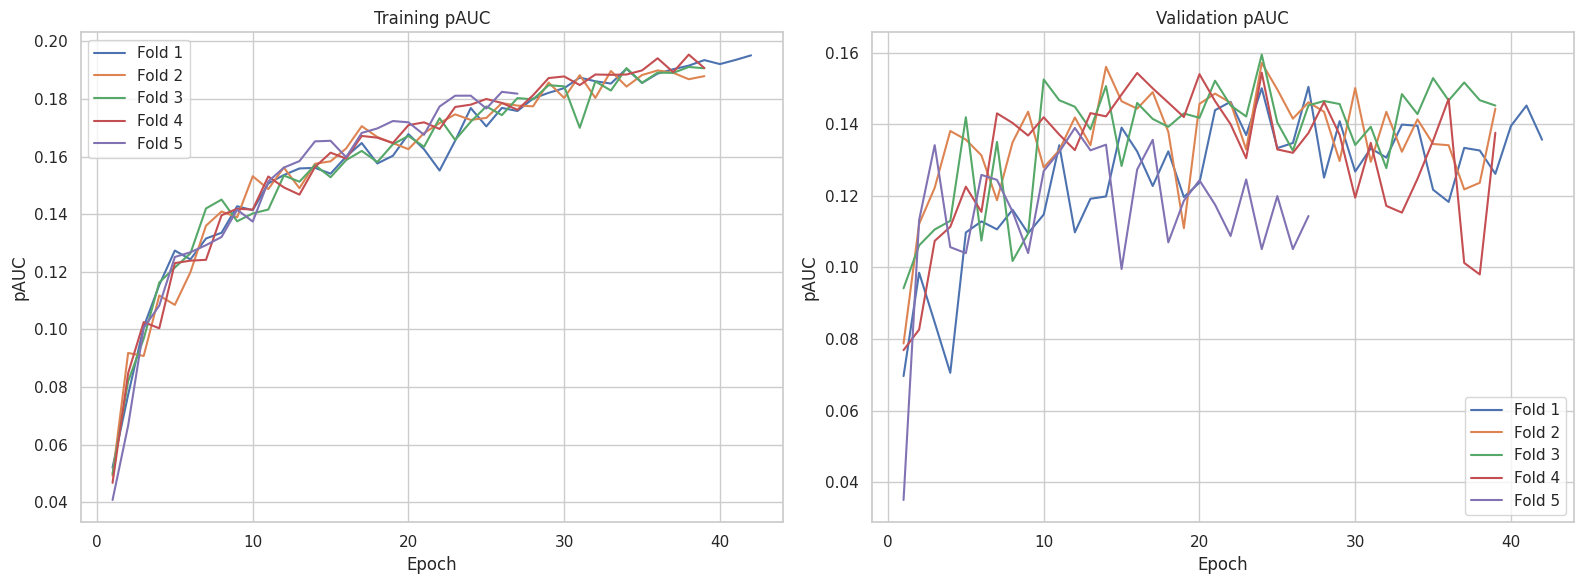

In [15]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_pauc', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training pAUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('pAUC')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_pauc', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation pAUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('pAUC')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()

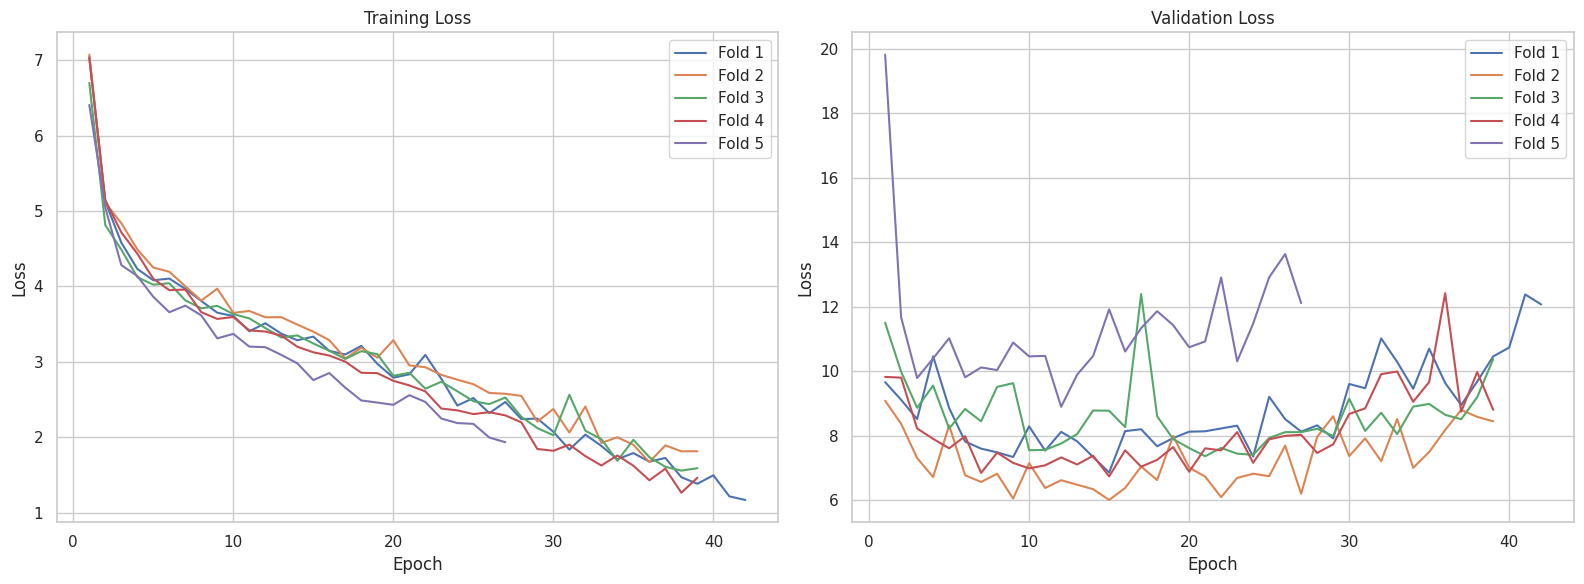

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_loss', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_loss', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()